In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../benchmark.csv')

del df['id']

df.head()

variants = df.columns

In [26]:
df_grouped = df[df['NumCandidates'] == 20].groupby(['Algorithm', 'NumVoters', 'NumCandidates'], as_index=False).agg({'Time': 'mean'})

# df_grouped['mean'] = df_grouped['Time']['mean']
# df_grouped['std'] = df_grouped['Time']['std']

In [27]:
df_grouped['Time'] = df_grouped['Time'].apply(lambda x: x/1000000)

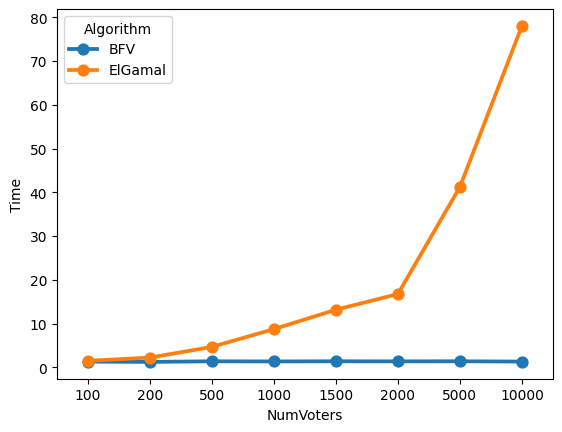

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pointplot(x='NumVoters', y='Time', data=df_grouped, hue='Algorithm', errorbar='sd')

plt.show()

In [3]:
statistics = {}

for variant in variants:
  statistics[variant] = {
    'mean': df[variant].mean(),
    'std': df[variant].std()
  }

In [4]:
parsed = {}

for entry in statistics:
  splited = entry.split('_')
  cipher = splited[-1]
  voters = splited[-2]
  candidates = splited[-3]
  func = splited[:-3]

  if '_'.join(func) not in parsed:
    parsed['_'.join(func)] = []
  
  parsed['_'.join(func)].append([cipher, voters, candidates, statistics[entry]['mean'], statistics[entry]['std']])

In [5]:
columns = ['Cryptosystem', 'Voters', 'Candidates', 'mean_time', 'stdev']

df_sum = pd.DataFrame(parsed['sum_ballots'], columns=columns)
df_decrypt = pd.DataFrame(parsed['decrypt_ballot'], columns=columns)

df_sum['Voters'] = pd.to_numeric(df_sum['Voters'])
df_decrypt['Voters'] = pd.to_numeric(df_decrypt['Voters'])

df_sum['Candidates'] = pd.to_numeric(df_sum['Candidates'])
df_decrypt['Candidates'] = pd.to_numeric(df_decrypt['Candidates'])


In [6]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cryptosystem  58 non-null     object 
 1   Voters        58 non-null     int64  
 2   Candidates    58 non-null     int64  
 3   mean_time     58 non-null     float64
 4   stdev         58 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.4+ KB


In [9]:
df_sum.head()

,Cryptosystem,Voters,Candidates,mean_time,stdev
0,BFV,750,5,2.014415e+09,2.557249e+07
1,BFV,200,5,5.313255e+08,3.537087e+06
2,ElGamal,1500,5,5.346380e+07,3.364371e+05
3,ElGamal,750,10,5.203898e+07,3.686451e+05
4,BFV,1500,20,3.927794e+09,5.745306e+06


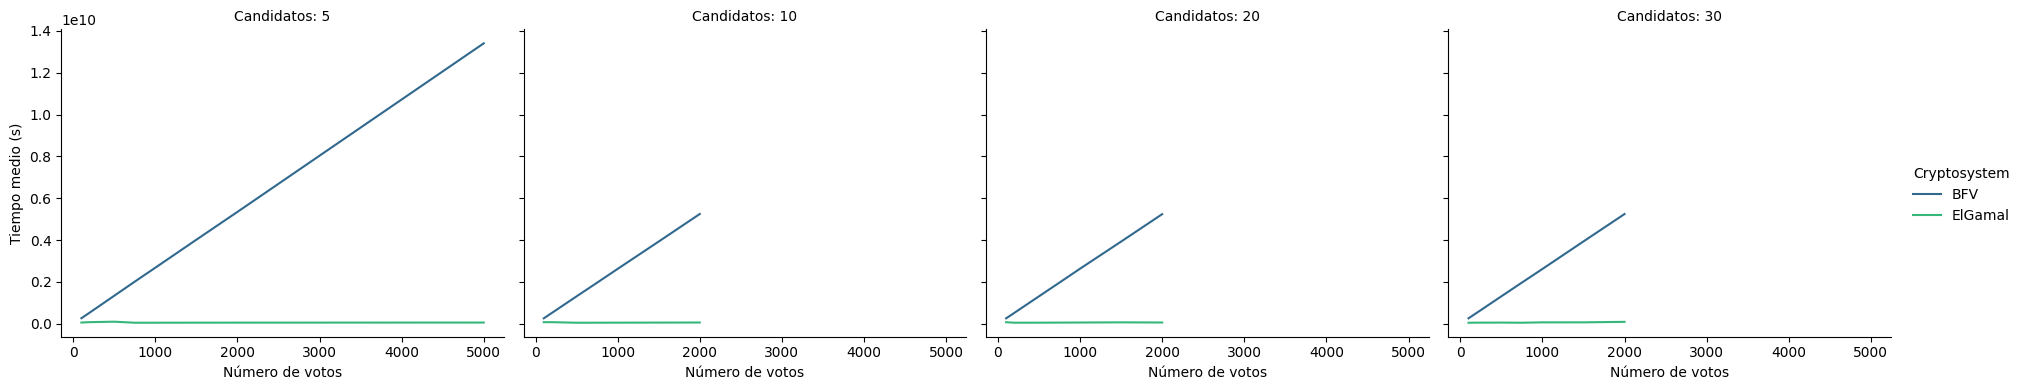

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(
    data=df_sum,
    x="Voters",
    y="mean_time",
    hue="Cryptosystem",
    col="Candidates",
    kind="line",
    errorbar="sd",  # Usar desviación estándar como intervalo
    palette="viridis",
    height=4,
    aspect=1.2
)
g.set_axis_labels("Número de votos", "Tiempo medio (s)")
g.set_titles("Candidatos: {col_name}")
plt.show()

In [11]:
heatmap_data_bfv = df_sum[df_sum['Cryptosystem'] == 'BFV'].pivot_table(
    index='Candidates',
    columns='Voters',
    values='mean_time',
    aggfunc='mean'  # Usar la media si hay duplicados
)

heatmap_data_elgamal = df_sum[df_sum['Cryptosystem'] == 'ElGamal'].pivot_table(
    index='Candidates',
    columns='Voters',
    values='mean_time',
    aggfunc='mean'
)

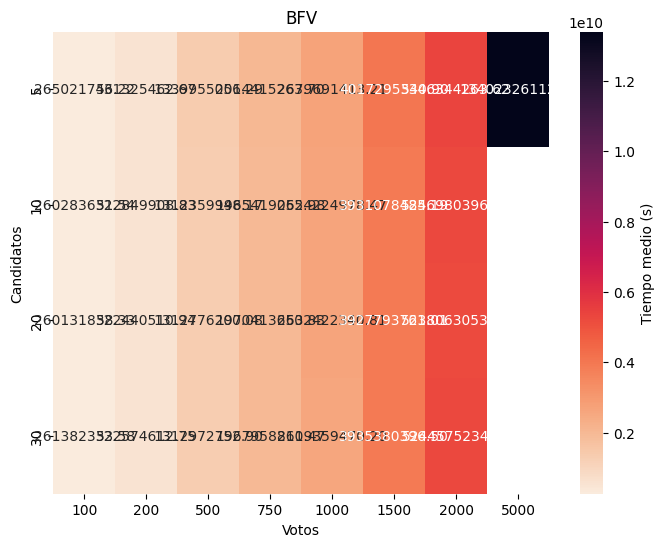

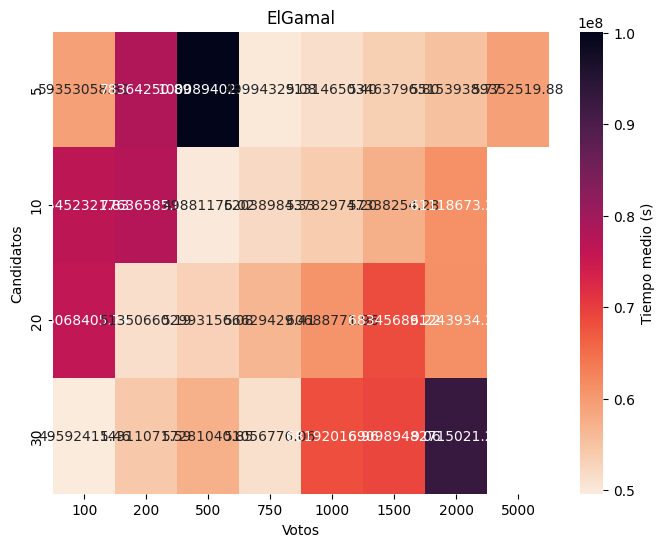

In [12]:
# Heatmap para BFV
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_bfv,
    annot=True,
    fmt=".2f",
    cmap="rocket_r",
    cbar_kws={'label': 'Tiempo medio (s)'}
)
plt.title('BFV')
plt.xlabel('Votos')
plt.ylabel('Candidatos')
plt.show()

# Heatmap para ElGamal
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_elgamal,
    annot=True,
    fmt=".2f",
    cmap="rocket_r",
    cbar_kws={'label': 'Tiempo medio (s)'}
)
plt.title('ElGamal')
plt.xlabel('Votos')
plt.ylabel('Candidatos')
plt.show()

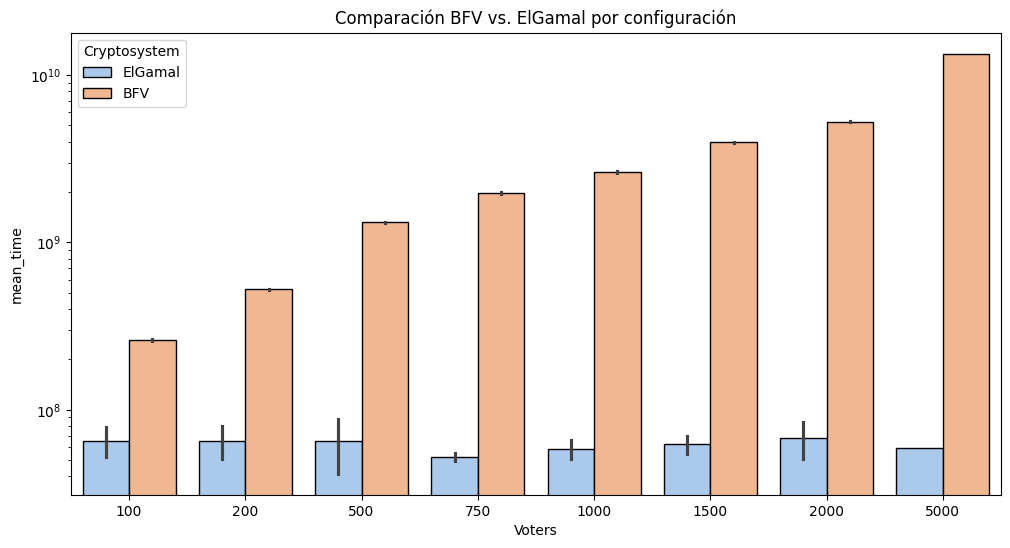

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_sum,
    x="Voters",
    y="mean_time",
    hue="Cryptosystem",
    errorbar="sd",
    palette="pastel",
    edgecolor="black"
)
plt.title("Comparación BFV vs. ElGamal por configuración")
plt.yscale("log")  # Si hay órdenes de magnitud de diferencia

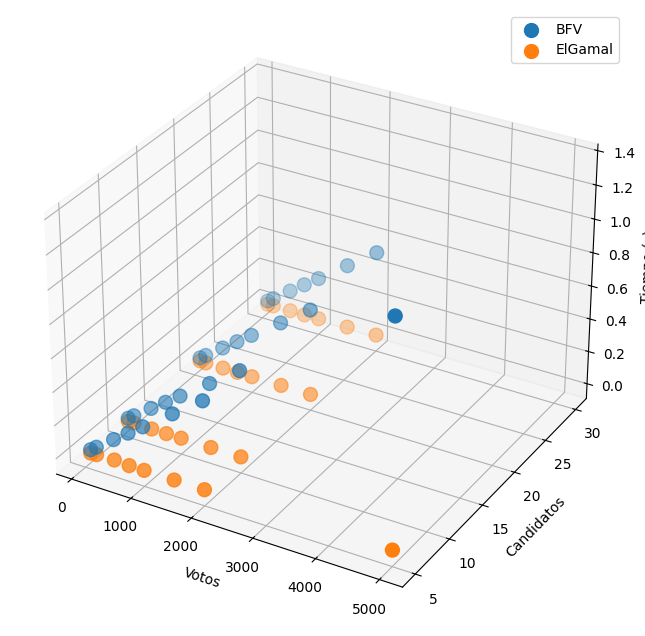

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
for algo in ["BFV", "ElGamal"]:
    subset = df_sum[df_sum.Cryptosystem == algo]
    ax.scatter(
        subset.Voters,
        subset.Candidates,
        subset.mean_time,
        label=algo,
        s=100
    )
ax.set_xlabel("Votos")
ax.set_ylabel("Candidatos")
ax.set_zlabel("Tiempo (s)")
plt.legend()

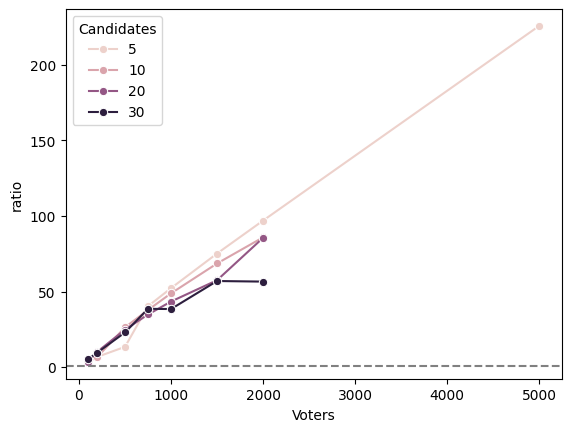

In [15]:
df_pivot = df_sum.pivot_table(
    index=["Voters", "Candidates"],
    columns="Cryptosystem",
    values="mean_time"
).reset_index()
df_pivot["ratio"] = df_pivot["BFV"] / df_pivot["ElGamal"]

sns.lineplot(
    data=df_pivot,
    x="Voters",
    y="ratio",
    hue="Candidates",
    marker="o"
)
plt.axhline(1, linestyle="--", color="gray")  # Línea de referencia

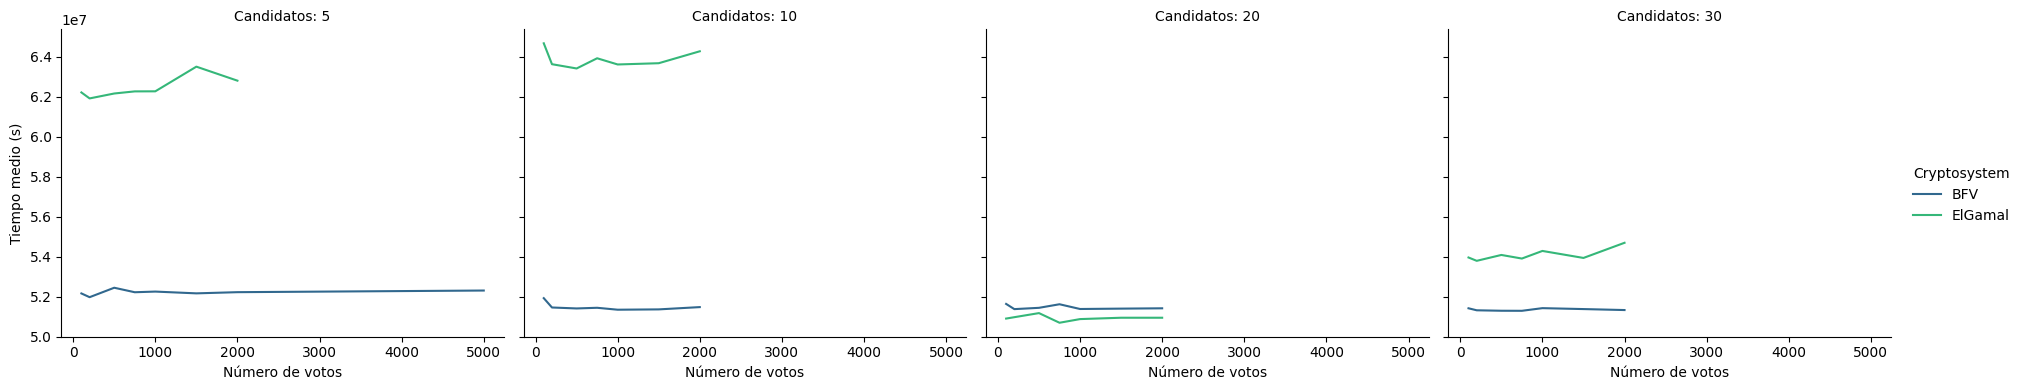

In [16]:
g = sns.relplot(
    data=df_decrypt,
    x="Voters",
    y="mean_time",
    hue="Cryptosystem",
    col="Candidates",
    kind="line",
    errorbar="sd",  # Usar desviación estándar como intervalo
    palette="viridis",
    height=4,
    aspect=1.2
)
g.set_axis_labels("Número de votos", "Tiempo medio (s)")
g.set_titles("Candidatos: {col_name}")
plt.show()

In [17]:
heatmap_data_bfv = df_decrypt[df_decrypt['Cryptosystem'] == 'BFV'].pivot_table(
    index='Candidates',
    columns='Voters',
    values='mean_time',
    aggfunc='mean'  # Usar la media si hay duplicados
)

heatmap_data_elgamal = df_decrypt[df_decrypt['Cryptosystem'] == 'ElGamal'].pivot_table(
    index='Candidates',
    columns='Voters',
    values='mean_time',
    aggfunc='mean'
)

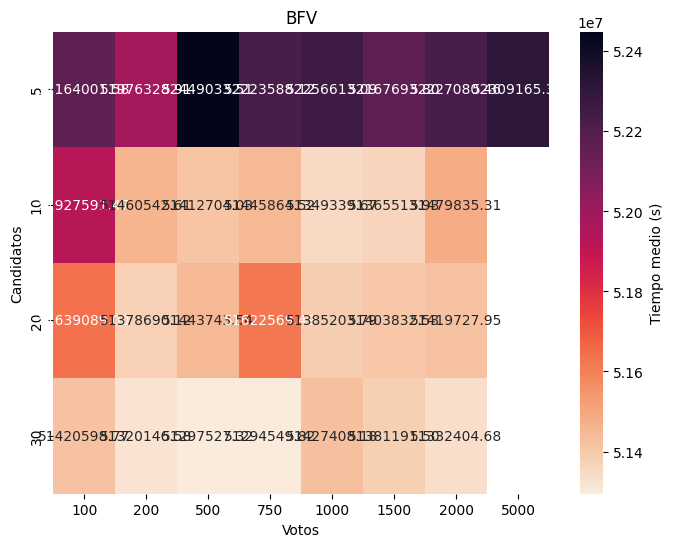

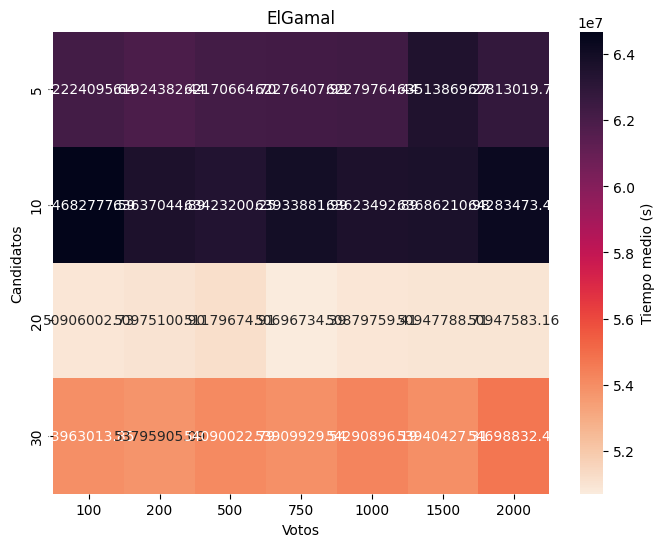

In [18]:
# Heatmap para BFV
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_bfv,
    annot=True,
    fmt=".2f",
    cmap="rocket_r",
    cbar_kws={'label': 'Tiempo medio (s)'}
)
plt.title('BFV')
plt.xlabel('Votos')
plt.ylabel('Candidatos')
plt.show()

# Heatmap para ElGamal
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_elgamal,
    annot=True,
    fmt=".2f",
    cmap="rocket_r",
    cbar_kws={'label': 'Tiempo medio (s)'}
)
plt.title('ElGamal')
plt.xlabel('Votos')
plt.ylabel('Candidatos')
plt.show()

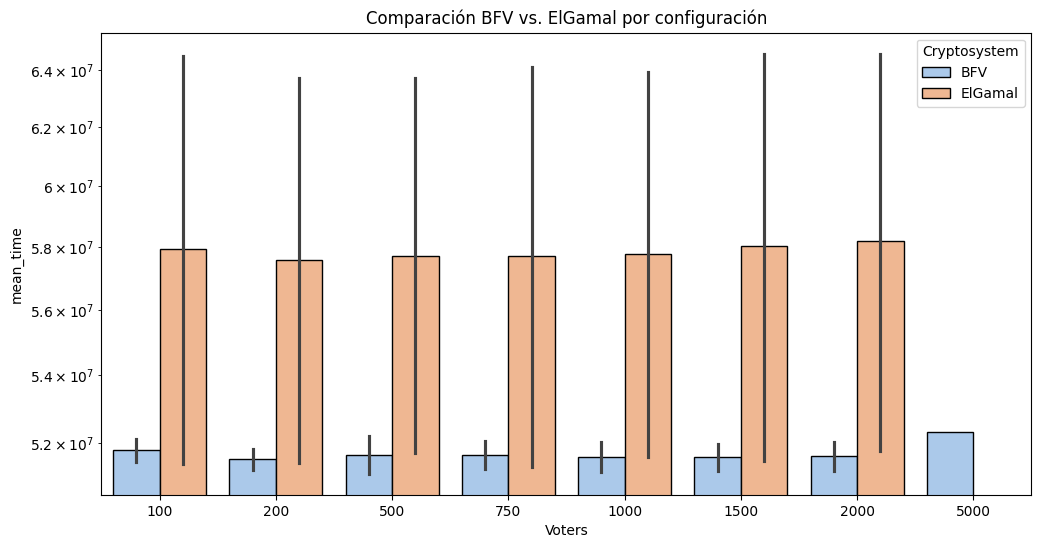

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_decrypt,
    x="Voters",
    y="mean_time",
    hue="Cryptosystem",
    errorbar="sd",
    palette="pastel",
    edgecolor="black"
)
plt.title("Comparación BFV vs. ElGamal por configuración")
plt.yscale("log")  # Si hay órdenes de magnitud de diferencia

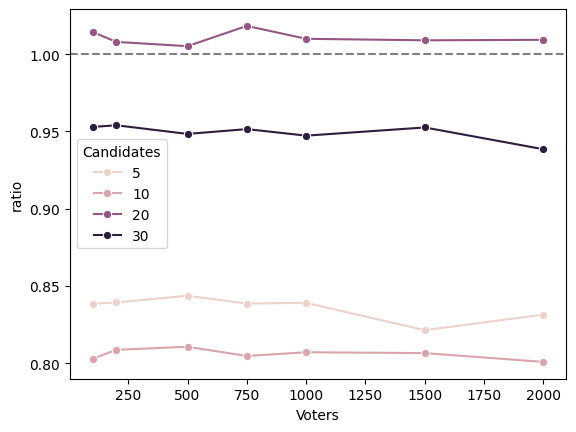

In [20]:
df_pivot = df_decrypt.pivot_table(
    index=["Voters", "Candidates"],
    columns="Cryptosystem",
    values="mean_time"
).reset_index()
df_pivot["ratio"] = df_pivot["BFV"] / df_pivot["ElGamal"]

sns.lineplot(
    data=df_pivot,
    x="Voters",
    y="ratio",
    hue="Candidates",
    marker="o"
)
plt.axhline(1, linestyle="--", color="gray")  # Línea de referencia